# Cross validaition

TODO: description

## Imports

First we import the required packages and `feems`:

In [1]:
# base
import numpy as np
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz
from feems.cv import run_cv

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

## Data

In [2]:
data_path = pkg_resources.resource_filename("feems", "data/")

# read the genotype data and mean impute missing data
(bim, fam, G) = read_plink("{}/wolvesadmix".format(data_path))
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
genotypes = imp.fit_transform((np.array(G)).T)

# setup graph
coord = np.loadtxt("{}/wolvesadmix.coord".format(data_path))  # sample coordinates
outer = np.loadtxt("{}/wolvesadmix.outer".format(data_path))  # outer coordinates
grid_path = "{}/grid_100.shp".format(data_path)  # path to discrete global grid

# graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=True, 
                                             buffer=0,
                                             outer=outer)

# construct spatial graph object
sp_graph = SpatialGraph(genotypes, coord, grid, edges, scale_snps=True)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 44.39it/s]


## Fit 

In [3]:
%%time
# fit null model and set alpha
sp_graph.fit_null_model()
alpha = 1.0 / sp_graph.w0[0]

# define grids
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-6, 1e2, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_graph, lamb_grid, factr=1e10)

# average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430

 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1CPU times: user 1min 33s, sys: 11.1 s, total: 1min 44s
Wall time: 1min 1s


Plot CV error:

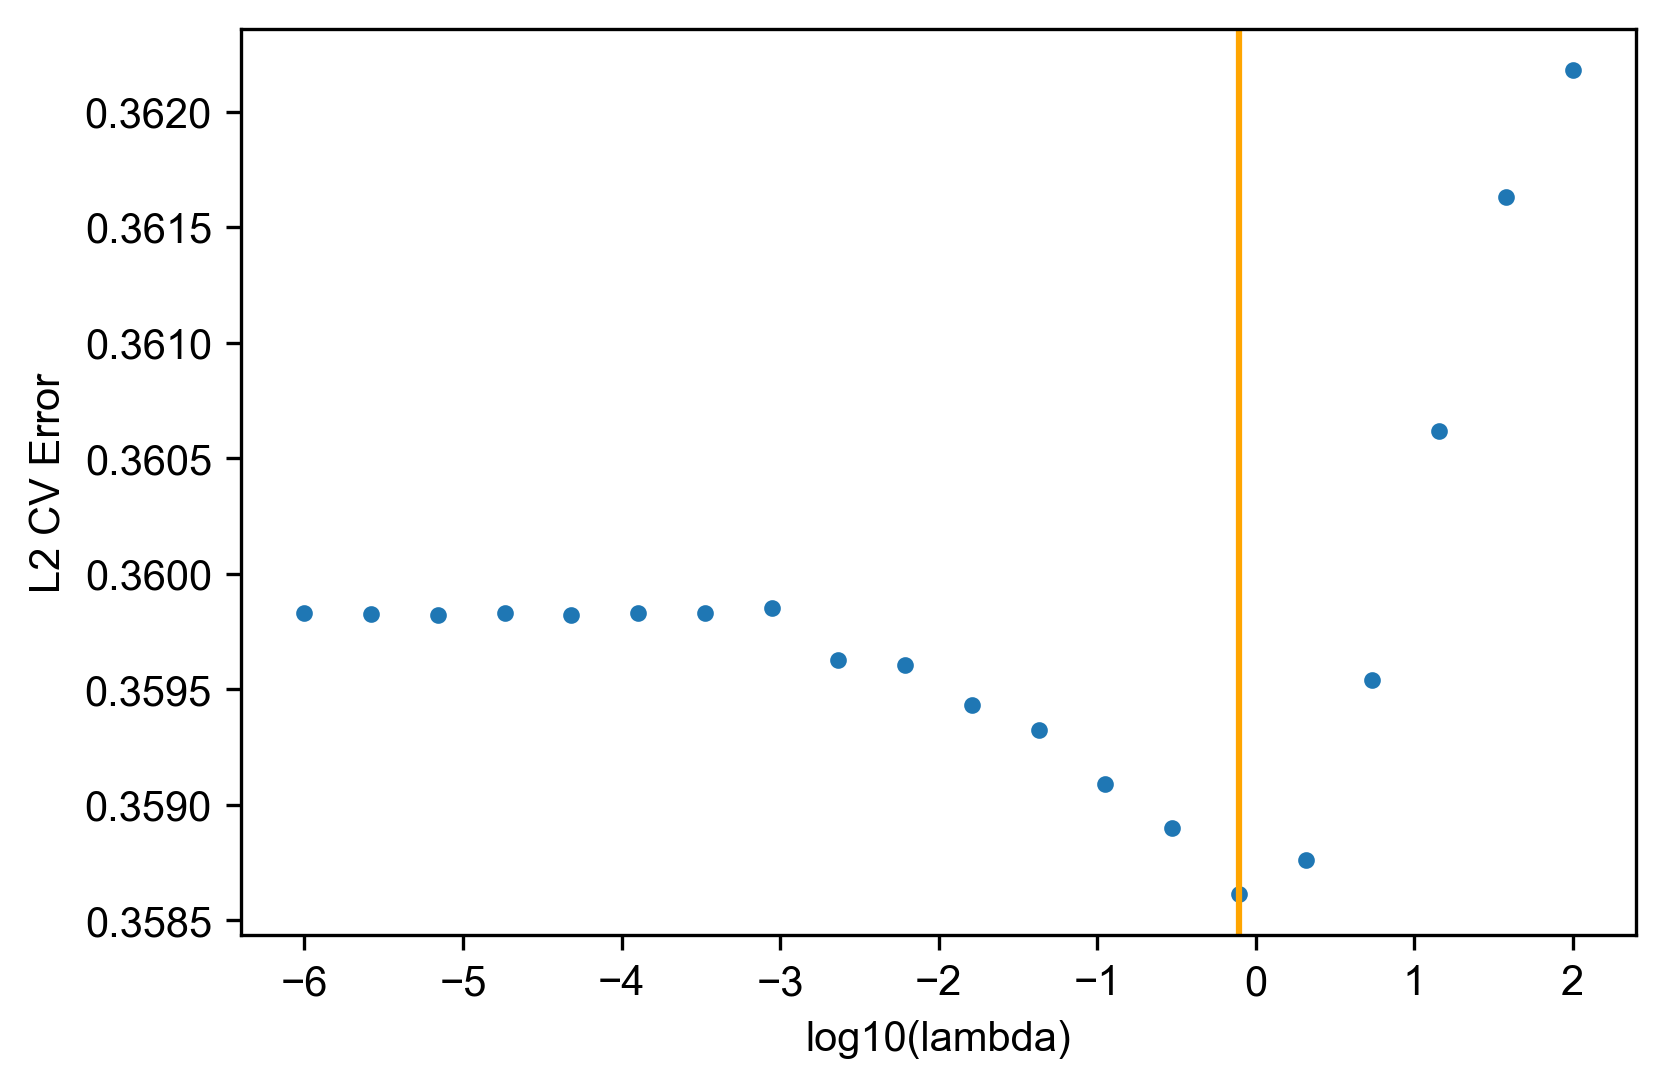

In [4]:
fig, ax = plt.subplots(dpi=300)
ax.plot(np.log10(lamb_grid), mean_cv_err, ".");
ax.set_xlabel("log10(lambda)");
ax.set_ylabel("L2 CV Error");
ax.axvline(np.log10(lamb_cv), color = "orange")

Re-fit spatial graph with $\lambda$ that acheives the minimum of the CV error curve:

In [5]:
sp_graph.fit(lamb_cv)

constant-w/variance fit, converged in 132 iterations, train_loss=2795677.6543430
lambda=0.7847600, alpha=0.8354260, converged in 97 iterations, train_loss=2761212.5861469


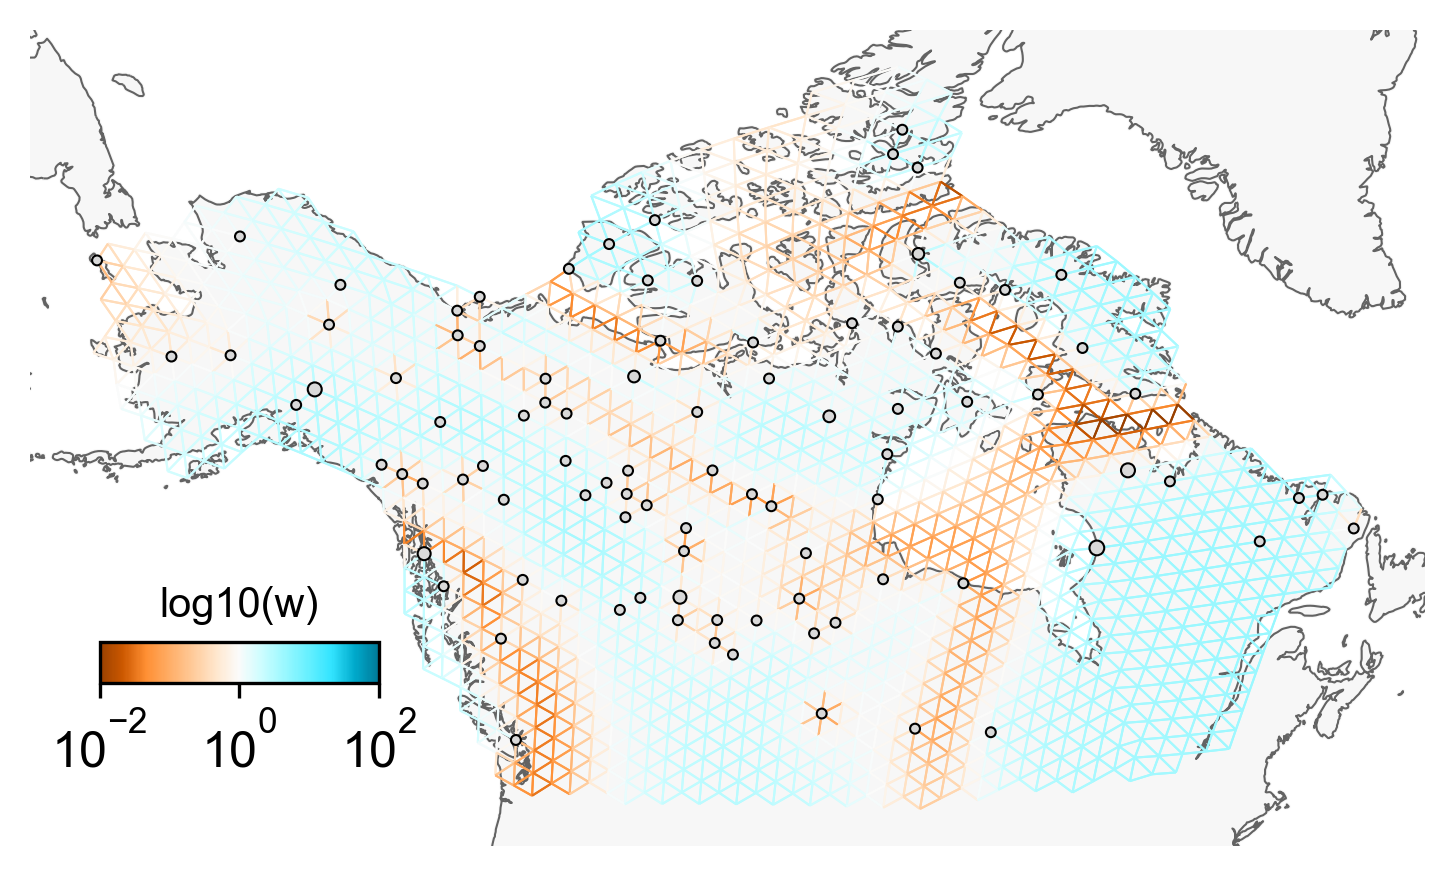

In [6]:
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)
fig = plt.figure(dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False) 
v.draw_edge_colorbar()